In [64]:
# Standard libraries
import numpy as np
import h5py
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
path2p = os.path.dirname(path1p)
path3p = os.path.dirname(path2p)
libpath = os.path.join(path2p, "lib")
pwd_rez = os.path.join(path3p, "data")

sys.path.insert(0, libpath)
print("Appended library directory", libpath)

# User libraries
import graph_lib
from signal_lib import resample
from fc.corr_lib import corr, crossCorr
#from analysis.metrics_network import diagDom
from data_io.qt_wrapper import gui_fnames, gui_fpath
from data_io.matlab_lib import loadmat
from data_io.yaro.yaro_data_read import read_neuro_perf, read_paw, read_lick, read_whisk
from data_io.yaro.yaro_data_parse_foldernames import parseFoldersMulti
from data_io.yaro.yaro_behaviour_preprocess import resample_lick, resample_paw, resample_whisk

%load_ext autoreload
%autoreload 2

Appended library directory /media/aleksejs/DataHDD/work/codes/comp-neuro/analysis-mesoscopic/mesoscopic-functional-connectivity/codes/lib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Automatically find subfolders for data and behaviour

In [2]:
tmp_path = root_path_data if 'root_path_data' in locals() else "./"
root_path_data  = gui_fpath("Path to data collection", tmp_path)
root_path_paw   = gui_fpath("Path to Paw data",        root_path_data)
root_path_lick  = gui_fpath("Path to Lick data",       root_path_paw)
root_path_whisk = gui_fpath("Path to Whisk Data",      root_path_lick)

In [3]:
pathDataSets, summary = parseFoldersMulti(root_path_data, root_path_paw, root_path_lick, root_path_whisk)

print("\n\nNumber of day folders for each mouse")
pd.DataFrame(summary)

Searching for channel labels
Searching for data files
Searching for paw files
Searching for lick files
Searching for whisk files


Number of day folders for each mouse


,Data,Lick,Paw,Whisk
mtp_12,24,20,30,17
mtp_15,13,13,0,14
mtp_2,8,8,0,10
mtp_1,9,11,0,11
mtp_7,18,23,4,24
mtp_16,13,13,0,14
mtp_10,8,10,11,8
mtp_11,12,15,6,11
mtp_13,12,13,8,10


# Read available data and behaviour, resample

In [4]:
def pd_filter(data, k, v):
    return data[data[k] == v]

In [5]:
# Read Neuronal data
N_DATA_FILES = pathDataSets['data_path'].shape[0]

dataNeuronal = []
dataTrials   = []
dataPerformance = []

progBar = IntProgress(min=0, max=N_DATA_FILES, description='Read Neuro Data:')
display(progBar) # display the bar
for datapath in pathDataSets['data_path']['path']:
    data, behaviour, performance = read_neuro_perf(datapath, verbose=False)
    dataNeuronal += [data]
    dataTrials   += [behaviour]
    dataPerformance += [performance]
    progBar.value += 1
dataPerformance = np.array(dataPerformance)
    
# Define resampling frequency
TARGET_RANGE = [0, 8] # Seconds goal
TARGET_FREQ = 20 # Hz
TARGET_NTIMES = int((TARGET_RANGE[1]-TARGET_RANGE[0])*TARGET_FREQ) + 1
TARGET_TIMES = np.linspace(TARGET_RANGE[0], TARGET_RANGE[1], TARGET_NTIMES)
print("Target trial within", TARGET_RANGE, "sec. Total target timesteps", TARGET_NTIMES)
    
# # Read and resample paw
# N_PAW_FILES = pathDataSets['paw_path'].shape[0]
# dataPawResampled = []
# progBar = IntProgress(min=0, max=N_PAW_FILES, description='Read paw data:')
# display(progBar) # display the bar
# for pawpath in pathDataSets['paw_path']['path']:
#     dataPaw = read_paw(pawpath, verbose=False)
#     dataPawResampled += [resample_paw(dataPaw, TARGET_TIMES, TARGET_FREQ)]
#     progBar.value += 1

# # Read and resample lick
# N_LICK_FILES = pathDataSets['lick_path'].shape[0]
# dataLickResampled = []
# progBar = IntProgress(min=0, max=N_LICK_FILES, description='Read lick data:')
# display(progBar) # display the bar

# for index, row in pathDataSets['lick_path'].iterrows():
#     # Find behaviour associated with this lick
#     dataIdxs = pd_filter(pathDataSets['data_path'], 'mousekey', row['mousekey']).index
#     if dataIdxs.shape[0] == 0:
#         dataLickResampled += [None]
#     else:
#         dataIdx = dataIdxs[0]
#         neuro = dataNeuronal[dataIdx]
#         behaviour = dataTrials[dataIdx]
#         dataLick = read_lick(row['path'], verbose=False)
#         dataLickResampled += [resample_lick(dataLick, neuro, behaviour, TARGET_TIMES, TARGET_FREQ)]
#     progBar.value += 1

# # Read and resample whisk
# N_WHISK_FILES = pathDataSets['whisk_path'].shape[0]
# progBar = IntProgress(min=0, max=N_WHISK_FILES, description='Read whisk data:')
# display(progBar) # display the bar
# dataWhiskResampled = []
# for whiskpath in pathDataSets['whisk_path']['path']:
#     dataWhisk = read_whisk(whiskpath, verbose=False)
#     dataWhiskResampled += [resample_whisk(dataWhisk, TARGET_TIMES)]
#     progBar.value += 1

IntProgress(value=0, description='Read Neuro Data:', max=117)

Behaviour has more trials than data 438 437
Behaviour max index must be less than number of trials 437 437
Target trial within [0, 8] sec. Total target timesteps 161


In [27]:
aaa = np.random.uniform(0,1,100)
bbb = np.where(aaa < 0.2)
bbb[0]
aaa.shape

(100,)

In [26]:
dataPerformance.shape

(117,)

# Analysis

## Performance

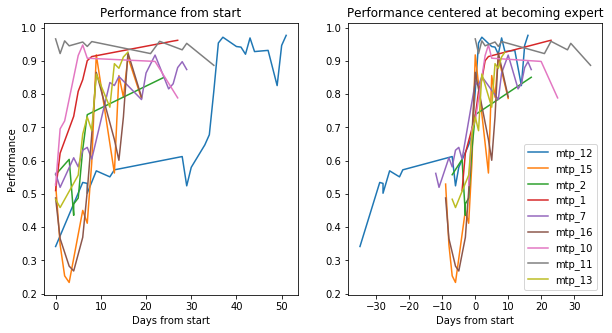

In [32]:
mice = list(set(pathDataSets['channel_labels']['mousename']))
dateDiff = lambda l: np.array([(v - l.iloc[0]).days for v in l])

deltaDays         = np.zeros(N_DATA_FILES)
deltaDaysCentered = np.zeros(N_DATA_FILES)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
for mousename in mice:
    mouseData = pd_filter(pathDataSets['data_path'], 'mousename', mousename)
    if mouseData.shape[0] > 0:        
        dataIdxs = np.array(mouseData["date"].index)
        
        perf = dataPerformance[dataIdxs]
        expertIdx = np.where(perf > 0.7)[0][0]
        
        deltaDays[dataIdxs] = dateDiff(mouseData["date"])
        deltaDaysCentered[dataIdxs] = deltaDays[dataIdxs] - deltaDays[dataIdxs][expertIdx]

            
        ax[0].plot(deltaDays[dataIdxs], perf, label=mousename)
        ax[1].plot(deltaDaysCentered[dataIdxs], perf, label=mousename)

ax[0].set_title("Performance from start")
ax[1].set_title("Performance centered at becoming expert")
ax[0].set_xlabel("Days from start")
ax[1].set_xlabel("Days from start")
ax[0].set_ylabel("Performance")
plt.legend()
plt.show()

## 1. Correlation and Synchrony

**THINGS TO TRY**:
1. MI instead of TE
2. Some clustering measure
3. Repeat for other mice

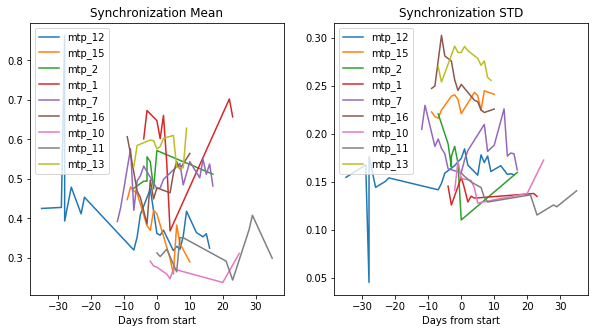

In [48]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

for mousename in mice:
    mouseData = pd_filter(pathDataSets['data_path'], 'mousename', mousename)
    if mouseData.shape[0] > 0:    
        dataIdxs = list(mouseData["date"].index)
        
        synchrMu = np.zeros(len(dataIdxs))
        synchrStd = np.zeros(len(dataIdxs))
        for i, dataIdx in enumerate(dataIdxs):
            dataThis = dataNeuronal[dataIdx].transpose(2,1,0) #channel x time x trial for cross-corr
            
            c = crossCorr(dataThis, 0, 0)[0]
            synchrMu[i], synchrStd[i] = diagonal_dominance(np.abs(c))
            
        ax[0].plot(deltaDaysCentered[dataIdxs], synchrMu, label=mousename)
        ax[1].plot(deltaDaysCentered[dataIdxs], synchrStd, label=mousename)

ax[0].set_title("Synchronization Mean")
ax[1].set_title("Synchronization STD")
ax[0].set_xlabel("Days from start")
ax[1].set_xlabel("Days from start")
ax[0].legend()
ax[1].legend()
plt.show()

## 1.2 Clustering of data

1. For each mouse, for each time, compute corr
2. Compute CC vs time (mean/var)
3. Plot for all mice
4. Then split Go/NoGO

mtp_12
-- mtp_12_2016_10_26_a


/media/aleksejs/DataHDD/work/codes/comp-neuro/analysis-mesoscopic/mesoscopic-functional-connectivity/codes/lib/graph_lib.py:48: RuntimeWarning: invalid value encountered in double_scalars
  return np.prod(v) ** (1 / len(v))


-- mtp_12_2016_11_01_a
-- mtp_12_2016_11_02_a
-- mtp_12_2016_11_02_b
-- mtp_12_2016_11_04_a
-- mtp_12_2016_11_07_a
-- mtp_12_2016_11_08_a
-- mtp_12_2016_11_23_a
-- mtp_12_2016_11_24_a
-- mtp_12_2016_11_25_a
-- mtp_12_2016_11_28_a
-- mtp_12_2016_11_29_a
-- mtp_12_2016_11_30_a
-- mtp_12_2016_12_01_a
-- mtp_12_2016_12_02_a
-- mtp_12_2016_12_05_a
-- mtp_12_2016_12_06_a
-- mtp_12_2016_12_07_a
-- mtp_12_2016_12_08_a
-- mtp_12_2016_12_09_a
-- mtp_12_2016_12_12_a
-- mtp_12_2016_12_14_a
-- mtp_12_2016_12_15_a
-- mtp_12_2016_12_16_a


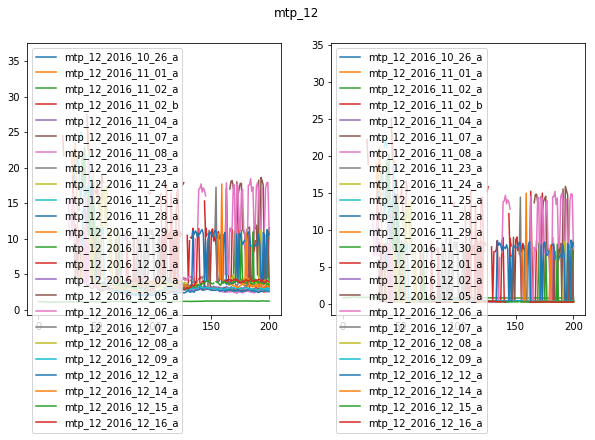

In [75]:
for mousename in mice[:1]:
    print(mousename)
    
    mouseData = pd_filter(pathDataSets['data_path'], 'mousename', mousename)
    if mouseData.shape[0] > 0:
        dataIdxs = list(mouseData["date"].index)
        
        fig, ax = plt.subplots(ncols=2, figsize=(10,5))
        fig.suptitle(mousename)
        
        for i, dataIdx in enumerate(dataIdxs):
            dataThis = dataNeuronal[dataIdx]
            dataLabel = pathDataSets['data_path']['mousekey'][dataIdx]
            
            print("--", dataLabel)
            
            nTrial, nTime, nChannel = dataThis.shape
            
            ccNormArr = np.zeros(nTime)
            ccNoNormArr = np.zeros(nTime)
            
            for iTime in range(nTime):
                corrThis = corr(dataThis[:, iTime, :].T)                
                ccNormArr[iTime]   = np.mean(graph_lib.cl_coeff(corrThis, normDegree=True))
                ccNoNormArr[iTime] = np.mean(graph_lib.cl_coeff(corrThis, normDegree=False))
            
            ax[0].plot(ccNormArr, label=dataLabel)
            ax[1].plot(ccNoNormArr, label=dataLabel)

        ax[0].legend()
        ax[1].legend()
        plt.show()